In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.applications.mobilenet_v3 import MobileNetV3Small
from keras.preprocessing.image import ImageDataGenerator

In [6]:
df = pd.read_csv('classifier.csv')

In [7]:
df.describe()

,img_dir,img_name,label
count,7253,7253,7253
unique,18,1601,3
top,D:\SAR Project Data\S1A_IW_GRDH_1SDV_20191114T...,719.png,water
freq,982,6,3611


In [8]:
dfd = df.drop_duplicates('img_name','last')
dfd.describe()

,img_dir,img_name,label
count,1601,1601,1601
unique,13,1601,3
top,D:\SAR Project Data\S1A_IW_GRDH_1SDV_20191121T...,266.png,water
freq,571,1,810


In [9]:
dfd['abs_path'] = (dfd['img_dir']+'\\'+dfd['img_name'])

<ipython-input-9-0c0f1bc238f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfd['abs_path'] = (dfd['img_dir']+'\\'+dfd['img_name'])


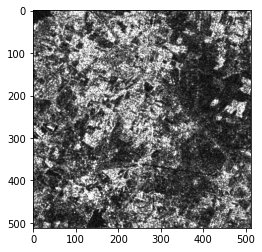

In [13]:
dfm = dfd.loc[dfd['label'] == 'land'].reset_index()
i = 290

i_p = os.path.join(dfm['img_dir'][i],dfm['img_name'][i])
img = plt.imread(i_p)
plt.imshow(img,cmap='gray')

In [14]:
dg = ImageDataGenerator(brightness_range=[0.2,1.8]
                        ,horizontal_flip=True,vertical_flip=True
                        ,validation_split=0.25
                        #,rotation_range=[90]
                        #,zoom_range=[0.5,1]
                       )

In [15]:
df['abs_path'] = (df['img_dir']+'\\'+df['img_name'])

In [26]:
t_it = dg.flow_from_dataframe(dataframe=df
                            ,x_col='abs_path'
                            ,y_col='label'
                            ,class_mode='categorical'
                            ,shuffle=True
                            ,target_size=(224,224)
                            ,subset='training'
                            ,batch_size=64
                           )

v_it = dg.flow_from_dataframe(dataframe=df
                            ,x_col='abs_path'
                            ,y_col='label'
                            ,class_mode='categorical'
                            ,shuffle=True
                            ,target_size=(224,224)
                            ,subset='validation'
                            ,batch_size=64
                           )

Found 5440 validated image filenames belonging to 3 classes.
Found 1813 validated image filenames belonging to 3 classes.


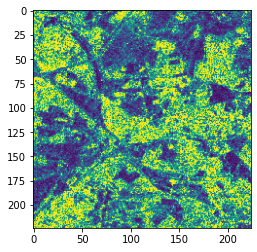

In [20]:
plt.imshow(t_it.next()[0][9,:,:,0])

In [23]:
base = MobileNetV3Small(weights='imagenet',include_top=False,pooling='avg')
base

6709248/6698480 [==============================] - 3s 0us/step


In [24]:
base.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, None, None, 1 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, None, None, 1 64          Conv[0][0]                       
___________________________________________________________________________________

In [27]:
mdl = Sequential([
    base
    ,Dropout(0.6)
    ,Dense(128,activation='relu')
    ,Dropout(0.6)
    ,Dense(64,activation='relu')
    ,Dense(25,activation='relu')
    ,Dropout(0.5)
    ,Dense(3,activation='softmax')
])

In [28]:
mdl.layers[0].trainable = False
mdl.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3small (Functional (None, 1024)              1529968   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1625      
_________________________________________________________________
dropout_5 (Dropout)          (None, 25)               

In [33]:
mdl.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

h = mdl.fit_generator(generator=t_it
                  ,validation_data=v_it
                  ,validation_steps=v_it.n//v_it.batch_size
                  ,steps_per_epoch=t_it.n//t_it.batch_size
                  ,epochs=2
                 )

Epoch 1/2
85/85 [==============================] - 329s 4s/step - loss: 0.2724 - acc: 0.9183 - val_loss: 0.1357 - val_acc: 0.9643
Epoch 2/2
85/85 [==============================] - 205s 2s/step - loss: 0.2231 - acc: 0.9399 - val_loss: 0.1228 - val_acc: 0.9648


In [34]:
h.history

{'loss': [0.26211515069007874, 0.21785402297973633],
 'acc': [0.9246323704719543, 0.9367647171020508],
 'val_loss': [0.13571400940418243, 0.12280677258968353],
 'val_acc': [0.9642857313156128, 0.96484375]}

In [35]:
mdl.evaluate_generator(generator=v_it,verbose=1,steps=v_it.n//v_it.batch_size)

28/28 [==============================] - 37s 1s/step - loss: 0.1204 - acc: 0.9688


[0.1204090490937233, 0.96875]

In [36]:
mdl.metrics_names

['loss', 'acc']

In [38]:
mdl.save('.\\lw_clf')

C:\Users\Tabish\AppData\Roaming\Python\Python39\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: .\lw_clf\assets


INFO:tensorflow:Assets written to: .\lw_clf\assets


[3.9663281e-02 9.6032172e-01 1.5005204e-05] [0. 1. 0.]


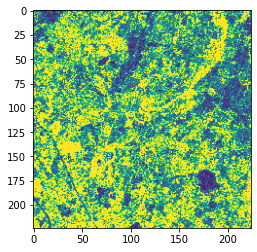

In [90]:
for x in t_it:
    plt.imshow(x[0][9,:,:,0])
    print(mdl.predict(x[0])[9],x[1][9])
    break

In [81]:
t_it.class_indices

{'l_w': 0, 'land': 1, 'water': 2}